PREDICTIVE MAINTENANCE ML SYSTEM

[1/9] Loading dataset...
Dataset shape: (10000, 14)
Columns: ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

[2/9] Preprocessing data...
  - Encoding 'Type' column...
  - Dropping target leakage columns: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
  - Dropping identifier columns: ['Product ID']

Features shape: (10000, 9)
Target shape: (10000,)
Cleaned column names: ['UDI', 'Air_temperature_K', 'Process_temperature_K', 'Rotational_speed_rpm', 'Torque_Nm', 'Tool_wear_min', 'Type_H', 'Type_L', 'Type_M']

Class distribution:
Machine failure
0    9661
1     339
Name: count, dtype: int64

Class percentages:
Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64

[3/9] Splitting data into train and test sets...
Training set: (8000, 9)
Test set: (2000, 9)

Training set class distribution:
Machine failure
0 

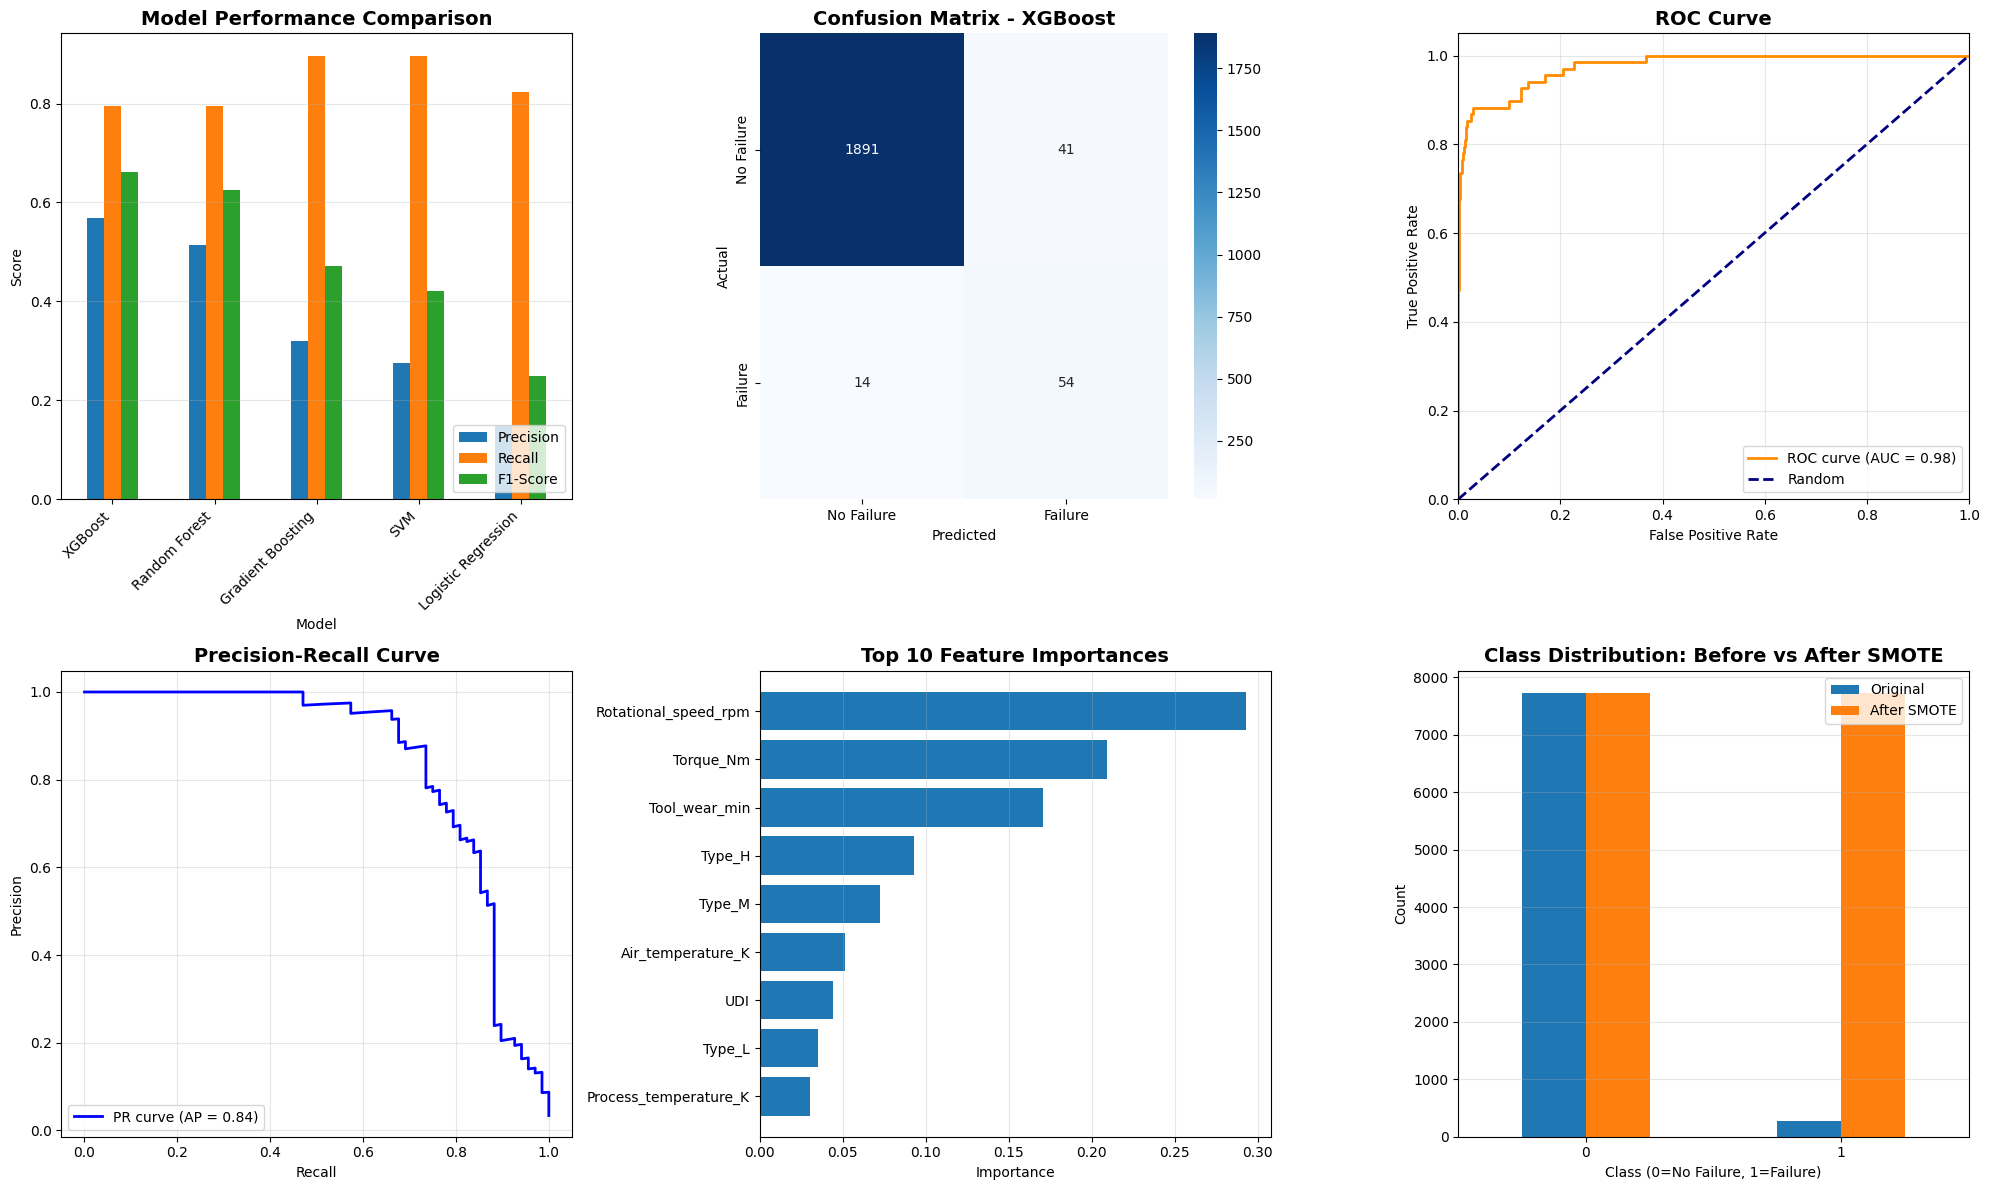

In [7]:
"""
PREDICTIVE MAINTENANCE MACHINE LEARNING SYSTEM
==============================================
This system predicts machine failure in advance using sensor data to reduce
downtime and maintenance costs.

Author: Machine Learning Pipeline
Date: 2026-02-09
"""


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score,
                             roc_curve, precision_recall_curve, f1_score, accuracy_score,
                             precision_score, recall_score, average_precision_score)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================================
# 1. LOAD AND PREPARE DATA
# ============================================================================
print("="*80)
print("PREDICTIVE MAINTENANCE ML SYSTEM")
print("="*80)

# Load dataset
print("\n[1/9] Loading dataset...")
df = pd.read_csv('ai4i2020.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

# ============================================================================
# 2. DATA PREPROCESSING
# ============================================================================
print("\n[2/9] Preprocessing data...")

# Create a copy
df_processed = df.copy()

# Encode 'Type' column if exists
if 'Type' in df_processed.columns:
    print("  - Encoding 'Type' column...")
    df_processed = pd.get_dummies(df_processed, columns=['Type'], prefix='Type', drop_first=False)

# Remove duplicates
duplicates = df_processed.duplicated().sum()
if duplicates > 0:
    print(f"  - Removing {duplicates} duplicate rows...")
    df_processed = df_processed.drop_duplicates()

# Define target and features
target_col = 'Machine failure'
failure_modes = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Drop failure mode columns (they are target leakage!)
columns_to_drop = [col for col in failure_modes if col in df_processed.columns]
if columns_to_drop:
    print(f"  - Dropping target leakage columns: {columns_to_drop}")
    df_processed = df_processed.drop(columns=columns_to_drop)

# Drop any identifier columns
id_cols = [col for col in df_processed.columns if col.lower() in ['uid', 'product id', 'id', 'index']]
if id_cols:
    print(f"  - Dropping identifier columns: {id_cols}")
    df_processed = df_processed.drop(columns=id_cols)

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

# Clean column names - remove special characters that cause issues with XGBoost
X.columns = X.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)
X.columns = X.columns.str.replace('<', '', regex=False).str.replace('>', '', regex=False)
X.columns = X.columns.str.replace(' ', '_')

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Cleaned column names: {X.columns.tolist()}")
print(f"\nClass distribution:")
print(y.value_counts())
print(f"\nClass percentages:")
print(y.value_counts(normalize=True) * 100)

# ============================================================================
# 3. TRAIN-TEST SPLIT
# ============================================================================
print("\n[3/9] Splitting data into train and test sets...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining set class distribution:\n{y_train.value_counts()}")
print(f"\nTest set class distribution:\n{y_test.value_counts()}")

# ============================================================================
# 4. FEATURE SCALING
# ============================================================================
print("\n[4/9] Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("  - Features scaled using StandardScaler")

# ============================================================================
# 5. HANDLE CLASS IMBALANCE WITH SMOTE
# ============================================================================
print("\n[5/9] Handling class imbalance with SMOTE...")

# Apply SMOTE only to training data
smote = SMOTE(random_state=RANDOM_STATE)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

print(f"Original training set: {X_train_scaled.shape}")
print(f"Resampled training set: {X_train_resampled.shape}")
print(f"\nResampled class distribution:\n{pd.Series(y_train_resampled).value_counts()}")

# ============================================================================
# 6. TRAIN MULTIPLE MODELS
# ============================================================================
print("\n[6/9] Training multiple models...")

# Define models to train
models = {
    'Logistic Regression': LogisticRegression(random_state=RANDOM_STATE, max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=100),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE, n_estimators=100, eval_metric='logloss'),
    'SVM': SVC(random_state=RANDOM_STATE, probability=True)
}

# Store trained models and results
trained_models = {}
results = []

for name, model in models.items():
    print(f"\n  Training {name}...")

    # Train the model
    model.fit(X_train_resampled, y_train_resampled)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 0

    # Store results
    results.append({
        'Model': name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'ROC-AUC': roc_auc
    })

    # Store trained model
    trained_models[name] = {
        'model': model,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"    Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f} | ROC-AUC: {roc_auc:.4f}")

# ============================================================================
# 7. MODEL COMPARISON
# ============================================================================
print("\n[7/9] Comparing model performance...")

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\nModel Performance Comparison:")
print("="*80)
print(results_df.to_string(index=False))

# Find best model based on F1-Score
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]['model']
best_predictions = trained_models[best_model_name]['predictions']
best_probabilities = trained_models[best_model_name]['probabilities']

print(f"\n🏆 Best Model: {best_model_name} (F1-Score: {results_df.iloc[0]['F1-Score']:.4f})")

# ============================================================================
# 8. DETAILED EVALUATION OF BEST MODEL
# ============================================================================
print("\n[8/9] Detailed evaluation of best model...")

print(f"\n{'='*80}")
print(f"DETAILED EVALUATION: {best_model_name}")
print(f"{'='*80}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, best_predictions, target_names=['No Failure', 'Failure']))

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
print("\nConfusion Matrix:")
print(cm)
print(f"\nTrue Negatives: {cm[0,0]} | False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}")

# Calculate business metrics
total_failures = cm[1,0] + cm[1,1]
detected_failures = cm[1,1]
missed_failures = cm[1,0]
false_alarms = cm[0,1]

print(f"\n📊 Business Metrics:")
print(f"  - Total actual failures: {total_failures}")
print(f"  - Failures detected: {detected_failures} ({detected_failures/total_failures*100:.1f}%)")
print(f"  - Failures missed: {missed_failures} ({missed_failures/total_failures*100:.1f}%)")
print(f"  - False alarms: {false_alarms}")

# Feature Importance (if available)
if hasattr(best_model, 'feature_importances_'):
    print("\n📈 Top 10 Most Important Features:")
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print(feature_importance.head(10).to_string(index=False))

# ============================================================================
# 9. HYPERPARAMETER TUNING FOR BEST MODEL
# ============================================================================
print("\n[9/9] Hyperparameter tuning for best model...")

# Define parameter grids for each model type
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Gradient Boosting': {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0]
    },
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l2'],
        'solver': ['lbfgs', 'liblinear']
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
}

if best_model_name in param_grids:
    print(f"  Tuning {best_model_name}...")

    # Create a new instance of the best model
    if best_model_name == 'Random Forest':
        model_to_tune = RandomForestClassifier(random_state=RANDOM_STATE)
    elif best_model_name == 'XGBoost':
        model_to_tune = XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss')
    elif best_model_name == 'Gradient Boosting':
        model_to_tune = GradientBoostingClassifier(random_state=RANDOM_STATE)
    elif best_model_name == 'Logistic Regression':
        model_to_tune = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    elif best_model_name == 'SVM':
        model_to_tune = SVC(random_state=RANDOM_STATE, probability=True)

    # Grid search with cross-validation
    grid_search = GridSearchCV(
        model_to_tune,
        param_grids[best_model_name],
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        scoring='f1',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train_resampled, y_train_resampled)

    print(f"\n  Best parameters: {grid_search.best_params_}")
    print(f"  Best cross-validation F1-score: {grid_search.best_score_:.4f}")

    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test_scaled)
    y_pred_proba_tuned = tuned_model.predict_proba(X_test_scaled)[:, 1]

    tuned_f1 = f1_score(y_test, y_pred_tuned)
    tuned_recall = recall_score(y_test, y_pred_tuned)
    tuned_precision = precision_score(y_test, y_pred_tuned)
    tuned_roc_auc = roc_auc_score(y_test, y_pred_proba_tuned)

    print(f"\n  Tuned model performance:")
    print(f"    F1-Score: {tuned_f1:.4f} (Original: {results_df.iloc[0]['F1-Score']:.4f})")
    print(f"    Recall: {tuned_recall:.4f} (Original: {results_df.iloc[0]['Recall']:.4f})")
    print(f"    Precision: {tuned_precision:.4f} (Original: {results_df.iloc[0]['Precision']:.4f})")
    print(f"    ROC-AUC: {tuned_roc_auc:.4f} (Original: {results_df.iloc[0]['ROC-AUC']:.4f})")

    # Use tuned model if it's better
    if tuned_f1 > results_df.iloc[0]['F1-Score']:
        print("\n  ✅ Tuned model is better! Using tuned model as final model.")
        best_model = tuned_model
        best_predictions = y_pred_tuned
        best_probabilities = y_pred_proba_tuned
    else:
        print("\n  ℹ️  Original model performs similarly or better. Keeping original model.")

# ============================================================================
# 10. VISUALIZATIONS
# ============================================================================
print("\n[10/10] Creating visualizations...")

# Create a figure with multiple subplots
fig = plt.figure(figsize=(20, 12))

# 1. Model Comparison Bar Chart
ax1 = plt.subplot(2, 3, 1)
results_df_plot = results_df.set_index('Model')
results_df_plot[['Precision', 'Recall', 'F1-Score']].plot(kind='bar', ax=ax1)
ax1.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Model')
ax1.legend(loc='lower right')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# 2. Confusion Matrix Heatmap
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2, cbar=True,
            xticklabels=['No Failure', 'Failure'],
            yticklabels=['No Failure', 'Failure'])
ax2.set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

# 3. ROC Curve
ax3 = plt.subplot(2, 3, 3)
if best_probabilities is not None:
    fpr, tpr, _ = roc_curve(y_test, best_probabilities)
    roc_auc = roc_auc_score(y_test, best_probabilities)
    ax3.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    ax3.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve', fontsize=14, fontweight='bold')
    ax3.legend(loc="lower right")
    ax3.grid(alpha=0.3)

# 4. Precision-Recall Curve
ax4 = plt.subplot(2, 3, 4)
if best_probabilities is not None:
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, best_probabilities)
    avg_precision = average_precision_score(y_test, best_probabilities)
    ax4.plot(recall_curve, precision_curve, color='blue', lw=2,
             label=f'PR curve (AP = {avg_precision:.2f})')
    ax4.set_xlabel('Recall')
    ax4.set_ylabel('Precision')
    ax4.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
    ax4.legend(loc="lower left")
    ax4.grid(alpha=0.3)

# 5. Feature Importance (if available)
ax5 = plt.subplot(2, 3, 5)
if hasattr(best_model, 'feature_importances_'):
    feature_imp = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=True).tail(10)

    ax5.barh(feature_imp['Feature'], feature_imp['Importance'])
    ax5.set_xlabel('Importance')
    ax5.set_title('Top 10 Feature Importances', fontsize=14, fontweight='bold')
    ax5.grid(axis='x', alpha=0.3)

# 6. Class Distribution
ax6 = plt.subplot(2, 3, 6)
class_dist = pd.DataFrame({
    'Original': y_train.value_counts().sort_index(),
    'After SMOTE': pd.Series(y_train_resampled).value_counts().sort_index()
})
class_dist.plot(kind='bar', ax=ax6)
ax6.set_title('Class Distribution: Before vs After SMOTE', fontsize=14, fontweight='bold')
ax6.set_xlabel('Class (0=No Failure, 1=Failure)')
ax6.set_ylabel('Count')
ax6.legend(['Original', 'After SMOTE'])
ax6.grid(axis='y', alpha=0.3)
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
plt.savefig('predictive_maintenance_analysis.png', dpi=300, bbox_inches='tight')
print("  - Saved visualization: predictive_maintenance_analysis.png")

# ============================================================================
# 11. SAVE MODEL AND ARTIFACTS
# ============================================================================
print("\n[11/11] Saving model and artifacts...")

# Save the best model
joblib.dump(best_model, 'best_model.pkl')
print("  - Saved model: best_model.pkl")

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("  - Saved scaler: scaler.pkl")

# Save model comparison results
results_df.to_csv('model_comparison.csv', index=False)
print("  - Saved results: model_comparison.csv")

# Save feature names
with open('feature_names.txt', 'w') as f:
    f.write('\n'.join(X_train.columns.tolist()))
print("  - Saved feature names: feature_names.txt")

# Save detailed evaluation report
with open('model_evaluation_report.txt', 'w') as f:
    f.write(f"PREDICTIVE MAINTENANCE MODEL EVALUATION REPORT\n")
    f.write(f"{'='*80}\n\n")
    f.write(f"Best Model: {best_model_name}\n")
    f.write(f"Date: 2026-02-09\n\n")
    f.write(f"MODEL PERFORMANCE\n")
    f.write(f"{'-'*80}\n")
    f.write(classification_report(y_test, best_predictions, target_names=['No Failure', 'Failure']))
    f.write(f"\n\nCONFUSION MATRIX\n")
    f.write(f"{'-'*80}\n")
    f.write(f"True Negatives: {cm[0,0]} | False Positives: {cm[0,1]}\n")
    f.write(f"False Negatives: {cm[1,0]} | True Positives: {cm[1,1]}\n")
    f.write(f"\n\nBUSINESS IMPACT\n")
    f.write(f"{'-'*80}\n")
    f.write(f"Total actual failures: {total_failures}\n")
    f.write(f"Failures detected: {detected_failures} ({detected_failures/total_failures*100:.1f}%)\n")
    f.write(f"Failures missed: {missed_failures} ({missed_failures/total_failures*100:.1f}%)\n")
    f.write(f"False alarms: {false_alarms}\n")

print("  - Saved report: model_evaluation_report.txt")

# ============================================================================
# 12. CREATE PREDICTION FUNCTION
# ============================================================================
print("\n[12/12] Creating prediction function for deployment...")

# Save a prediction script
prediction_script = """
import joblib
import pandas as pd
import numpy as np

# Load saved model and scaler
model = joblib.load('best_model.pkl')
scaler = joblib.load('scaler.pkl')

def predict_machine_failure(sensor_data):
    \"\"\"
    Predict machine failure based on sensor data.

    Parameters:
    -----------
    sensor_data : dict or pd.DataFrame
        Sensor readings with features matching training data

    Returns:
    --------
    dict : Prediction results including probability and recommendation
    \"\"\"
    # Convert to DataFrame if dict
    if isinstance(sensor_data, dict):
        sensor_data = pd.DataFrame([sensor_data])

    # Scale features
    sensor_data_scaled = scaler.transform(sensor_data)

    # Make prediction
    prediction = model.predict(sensor_data_scaled)[0]
    probability = model.predict_proba(sensor_data_scaled)[0, 1]

    # Generate recommendation
    if prediction == 1:
        if probability > 0.8:
            risk_level = "HIGH RISK"
            recommendation = "Immediate maintenance required! Schedule urgent inspection."
        elif probability > 0.6:
            risk_level = "MEDIUM RISK"
            recommendation = "Maintenance recommended within 24 hours."
        else:
            risk_level = "LOW-MEDIUM RISK"
            recommendation = "Schedule maintenance within next few days."
    else:
        risk_level = "LOW RISK"
        recommendation = "Machine operating normally. Continue monitoring."

    return {
        'failure_predicted': bool(prediction),
        'failure_probability': float(probability),
        'risk_level': risk_level,
        'recommendation': recommendation
    }

# Example usage:
if __name__ == "__main__":
    # Example sensor reading
    example_data = {
        'Air temperature [K]': 298.5,
        'Process temperature [K]': 309.0,
        'Rotational speed [rpm]': 1500,
        'Torque [Nm]': 45.0,
        'Tool wear [min]': 30,
        'Type_H': 0,
        'Type_L': 1,
        'Type_M': 0
    }

    result = predict_machine_failure(example_data)
    print("Prediction Result:")
    print(f"  Failure Predicted: {result['failure_predicted']}")
    print(f"  Failure Probability: {result['failure_probability']:.2%}")
    print(f"  Risk Level: {result['risk_level']}")
    print(f"  Recommendation: {result['recommendation']}")
"""

with open('predict.py', 'w') as f:
    f.write(prediction_script)

print("  - Saved prediction script: predict.py")

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("PREDICTIVE MAINTENANCE SYSTEM - COMPLETE!")
print("="*80)

print(f"""
✅ SYSTEM SUMMARY
-----------------
Best Model: {best_model_name}
F1-Score: {results_df.iloc[0]['F1-Score']:.4f}
Recall (Failure Detection Rate): {results_df.iloc[0]['Recall']:.4f}
Precision: {results_df.iloc[0]['Precision']:.4f}
ROC-AUC: {results_df.iloc[0]['ROC-AUC']:.4f}

📊 BUSINESS IMPACT
------------------
- Detects {detected_failures}/{total_failures} failures ({detected_failures/total_failures*100:.1f}%)
- Misses {missed_failures} failures ({missed_failures/total_failures*100:.1f}%)
- Generates {false_alarms} false alarms

📁 FILES GENERATED
------------------
1. best_model.pkl - Trained model ready for deployment
2. scaler.pkl - Feature scaler
3. predict.py - Prediction function for production use
4. predictive_maintenance_analysis.png - Comprehensive visualizations
5. model_comparison.csv - Performance comparison of all models
6. model_evaluation_report.txt - Detailed evaluation report
7. feature_names.txt - List of features used

🚀 DEPLOYMENT INSTRUCTIONS
--------------------------
1. Use predict.py for making predictions in production
2. Example usage:

   from predict import predict_machine_failure

   sensor_data = {{
       'Air temperature [K]': 298.5,
       'Process temperature [K]': 309.0,
       'Rotational speed [rpm]': 1500,
       'Torque [Nm]': 45.0,
       'Tool wear [min]': 30,
       'Type_H': 0, 'Type_L': 1, 'Type_M': 0
   }}

   result = predict_machine_failure(sensor_data)
   print(result)

💡 RECOMMENDATIONS
------------------
1. Monitor false positive rate to avoid unnecessary maintenance
2. Regularly retrain model with new data
3. Set up alerts for high-risk predictions (probability > 0.8)
4. Track maintenance costs saved vs false alarm costs
5. Consider ensemble of top 3 models for more robust predictions

The system is ready for deployment! 🎉
""")

print("="*80)